In [1]:
import os
import json
import numpy as np
import pandas as pd

In [2]:
# Load ground_truth_annotations.csv
ground_truth = pd.read_csv('data/ground_truth_annotations.csv', usecols=['image', 'label', 'unit', 'value'])

# Extract image names
ground_truth['image'] = ground_truth['image'].apply(lambda x: x.split('/')[-1].replace('.jpg', ''))
ground_truth.set_index('image', inplace=True)

# Get approximate bar size
def get_bar_size(row):
    if pd.isnull(row['label']):
        return None
    for item in np.array(eval(row['label'])):
        if item['rectanglelabels'] == ['bar']:
            if item['width'] > item['height']:
                return item['width'] * item['original_width'] / 100
            else:
                return item['height'] * item['original_height'] / 100
    return None
ground_truth['bar_size'] = ground_truth.apply(get_bar_size, axis=1)

# Load predictions
dfs = []
for filename in os.listdir('outputs/'):
    if filename.endswith('.json'):
        with open(os.path.join('outputs/', filename), 'r') as f:
            data = json.load(f)
            df = pd.json_normalize(data)
            df['image'] = filename.removesuffix('.json')
            dfs.append(df)

predictions = pd.concat(dfs, ignore_index=True).set_index('image')

/var/folders/k4/f_bpyr193w1dyd_9bdnnr3pc0000gn/T/ipykernel_7464/2571549159.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions = pd.concat(dfs, ignore_index=True).set_index('image')


In [3]:
# Merge ground truth and predictions
merged = pd.merge(ground_truth, predictions, left_index=True, right_index=True, how='outer')

In [4]:
merged[merged['scale_bar_found'].isnull()]

label  \
image                                                                        
BIOUG55573-B01.b947fdea                                                NaN   
BIOUG73869-A07.acab95e6  [{"x":93.59911881268391,"y":95.17988150422654,...   
BIOUG84644-D08.23526ac2  [{"x":88.81472495762065,"y":99.43752208838607,...   
BIOUG84644-D08.9ff5428a  [{"x":97.09359904752736,"y":97.26959629806362,...   
BIOUG84663-G11.bc65b007  [{"x":92.66116826122824,"y":97.56189921067293,...   
NSWHA1672-23             [{"x":92.44415300503711,"y":2.8558696663943226...   

                        unit  value    bar_size scale_bar_found  \
image                                                             
BIOUG55573-B01.b947fdea  NaN    NaN         NaN             NaN   
BIOUG73869-A07.acab95e6   mm    1.0  399.670055             NaN   
BIOUG84644-D08.23526ac2   um  500.0  383.415800             NaN   
BIOUG84644-D08.9ff5428a   um  500.0  343.924960             NaN   
BIOUG84663-G11.bc65b007   um  100.0  251.445533             NaN   
NSWHA1672-23              mm    5.0   73.732748             NaN   

                         measured_scale_length  declared_scale_length units  \
image                                                                         
BIOUG55573-B01.b947fdea                    NaN                    NaN   NaN   
BIOUG73869-A07.acab95e6                    NaN                    NaN   NaN   
BIOUG84644-D08.23526ac2                    NaN                    NaN   NaN   
BIOUG84644-D08.9ff5428a                    NaN                    NaN   NaN   
BIOUG84663-G11.bc65b007                    NaN                    NaN   NaN   
NSWHA1672-23                               NaN                    NaN   NaN   

                         pixel_to_mm_ratio orientation  scale_bar_confidence  \
image                                                                          
BIOUG55573-B01.b947fdea                NaN         NaN                   NaN   
BIOUG73869-A07.acab95e6                NaN         NaN                   NaN   
BIOUG84644-D08.23526ac2                NaN         NaN                   NaN   
BIOUG84644-D08.9ff5428a                NaN         NaN                   NaN   
BIOUG84663-G11.bc65b007                NaN         NaN                   NaN   
NSWHA1672-23                           NaN         NaN                   NaN   

                         text_label_confidence  orientation_confidence  
image                                                                   
BIOUG55573-B01.b947fdea                    NaN                     NaN  
BIOUG73869-A07.acab95e6                    NaN                     NaN  
BIOUG84644-D08.23526ac2                    NaN                     NaN  
BIOUG84644-D08.9ff5428a                    NaN                     NaN  
BIOUG84663-G11.bc65b007                    NaN                     NaN  
NSWHA1672-23                               NaN                     NaN

In [5]:
# Compare ground truth and predictions
detection = merged.dropna(subset=['scale_bar_found']).copy()
recognition = detection[detection['label'].notnull()]

results = {
    'total_images': len(detection),
    'correct_detections': (detection['scale_bar_found'] == detection['label'].notnull()).mean(),
    'correct_labels_values': (recognition['declared_scale_length'] == recognition['value']).mean(),
    'correct_labels_units': (recognition['units'] == recognition['unit']).mean(),
    'correct_labels' : ((recognition['declared_scale_length'] == recognition['value']) & (recognition['units'] == recognition['unit'])).mean(),
    'correct_bar_size': (np.abs(recognition['measured_scale_length'] - recognition['bar_size']) / recognition['bar_size'] <= 0.05).mean(),
    'bar_size_MAE': np.mean(np.abs(recognition['measured_scale_length'] - recognition['bar_size'])),
    'bar_size_normalized_MAE': np.mean(np.abs(recognition['measured_scale_length'] - recognition['bar_size']) / recognition['bar_size']),
}
results

{'total_images': 648,
 'correct_detections': 0.9830246913580247,
 'correct_labels_values': 0.9315068493150684,
 'correct_labels_units': 0.9315068493150684,
 'correct_labels': 0.9315068493150684,
 'correct_bar_size': 0.8972602739726028,
 'bar_size_MAE': 14.70717188341448,
 'bar_size_normalized_MAE': 0.042417983611197724}

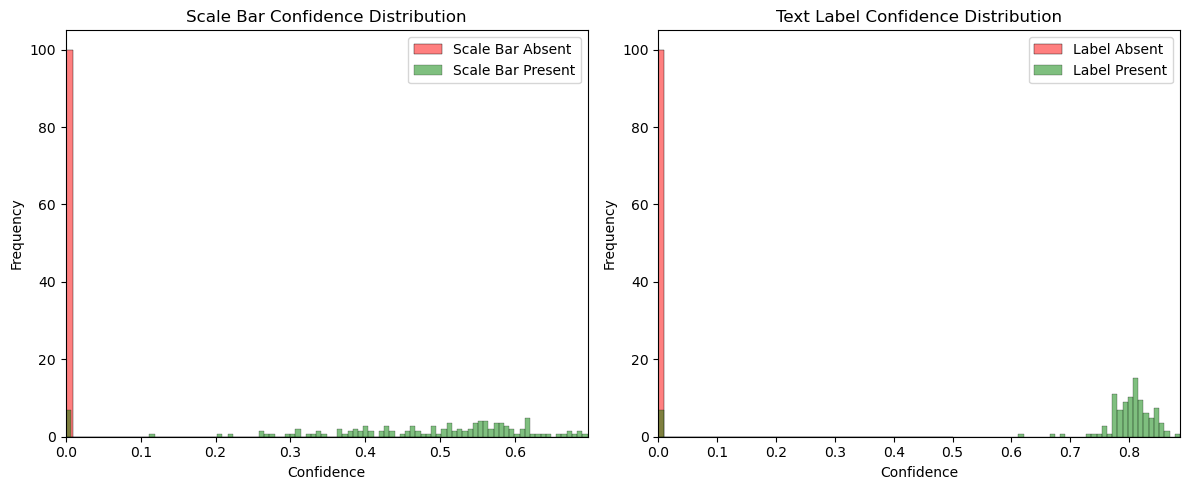

In [6]:
# Visualize confidence distributions
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(detection[detection['label'].isnull()]['scale_bar_confidence'], stat='percent', bins=100, color='red', alpha=0.5, label='Scale Bar Absent')
sns.histplot(detection[detection['label'].notnull()]['scale_bar_confidence'], stat='percent', bins=100, color='green', alpha=0.5, label='Scale Bar Present')
plt.legend()
plt.title('Scale Bar Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.xlim(np.min(detection['scale_bar_confidence']), np.max(detection['scale_bar_confidence']))
plt.subplot(1, 2, 2)
sns.histplot(detection[detection['value'].isnull() | detection['value'] == 0]['text_label_confidence'], stat='percent', bins=100, color='red', alpha=0.5, label='Label Absent')
sns.histplot(detection[detection['value'].notnull() & (detection['value'] > 0)]['text_label_confidence'], stat='percent', bins=100, color='green', alpha=0.5, label='Label Present')
plt.legend()
plt.title('Text Label Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.xlim(np.min(detection['text_label_confidence']), np.max(detection['text_label_confidence']))
plt.tight_layout()
plt.show()

In [7]:
detection

label  \
image                                                                                                   
BIOUG38212-G08.6c717ec2                             [{"x":86.01861177693473,"y":93.04564077899184,...   
BIOUG38212-G08.e7951709                                                                           NaN   
BIOUG51518-D10.aa1135bd                                                                           NaN   
BIOUG51518-D10.d16c5af6                             [{"x":90.10686418600262,"y":94.47673862601131,...   
BIOUG52793-A01.07798c22                                                                           NaN   
...                                                                                               ...   
NSWHA1671-23                                        [{"x":92.50650108375584,"y":96.67898215615078,...   
caos-cloud.linode-us-east.12_228.51b80d5d-30fe-...  [{"x":89.6724759127607,"y":94.90079950165934,"...   
caos-cloud.linode-us-east.16_237.1606d0ef-66ab-...  [{"x":93.95491730849064,"y":96.37086196973293,...   
caos-cloud.linode-us-east.16_293.37b8f000-9116-...  [{"x":86.6031492710147,"y":95.3695035579216,"w...   
caos-cloud.linode-us-ord-1.24_245.80b92524-4b82...                                                NaN   

                                                   unit  value    bar_size  \
image                                                                        
BIOUG38212-G08.6c717ec2                              um  300.0  298.033104   
BIOUG38212-G08.e7951709                             NaN    NaN         NaN   
BIOUG51518-D10.aa1135bd                             NaN    NaN         NaN   
BIOUG51518-D10.d16c5af6                              um  500.0  248.134142   
BIOUG52793-A01.07798c22                             NaN    NaN         NaN   
...                                                 ...    ...         ...   
NSWHA1671-23                                         mm    5.0   98.147042   
caos-cloud.linode-us-east.12_228.51b80d5d-30fe-...   um  500.0  497.041992   
caos-cloud.linode-us-east.16_237.1606d0ef-66ab-...   um  500.0  504.242704   
caos-cloud.linode-us-east.16_293.37b8f000-9116-...   mm    1.0  480.679004   
caos-cloud.linode-us-ord-1.24_245.80b92524-4b82...  NaN    NaN         NaN   

                                                   scale_bar_found  \
image                                                                
BIOUG38212-G08.6c717ec2                                       True   
BIOUG38212-G08.e7951709                                      False   
BIOUG51518-D10.aa1135bd                                      False   
BIOUG51518-D10.d16c5af6                                       True   
BIOUG52793-A01.07798c22                                      False   
...                                                            ...   
NSWHA1671-23                                                  True   
caos-cloud.linode-us-east.12_228.51b80d5d-30fe-...            True   
caos-cloud.linode-us-east.16_237.1606d0ef-66ab-...            True   
caos-cloud.linode-us-east.16_293.37b8f000-9116-...            True   
caos-cloud.linode-us-ord-1.24_245.80b92524-4b82...           False   

                                                    measured_scale_length  \
image                                                                       
BIOUG38212-G08.6c717ec2                                             290.0   
BIOUG38212-G08.e7951709                                               NaN   
BIOUG51518-D10.aa1135bd                                               NaN   
BIOUG51518-D10.d16c5af6                                             240.0   
BIOUG52793-A01.07798c22                                               NaN   
...                                                                   ...   
NSWHA1671-23                                                         95.0   
caos-cloud.linode-us-east.12_228.51b80d5d-30fe-...                  484.0   
caos-cloud.linode-us-east.16_237.1

Number of error cases: 12 out of 648
Image: BIOUG84644-D08.81cc1824, Scale Bar Found: False, Label Present: True
Image file for BIOUG84644-D08.81cc1824 not found.
Image file for BIOUG84644-D08.81cc1824 not found.


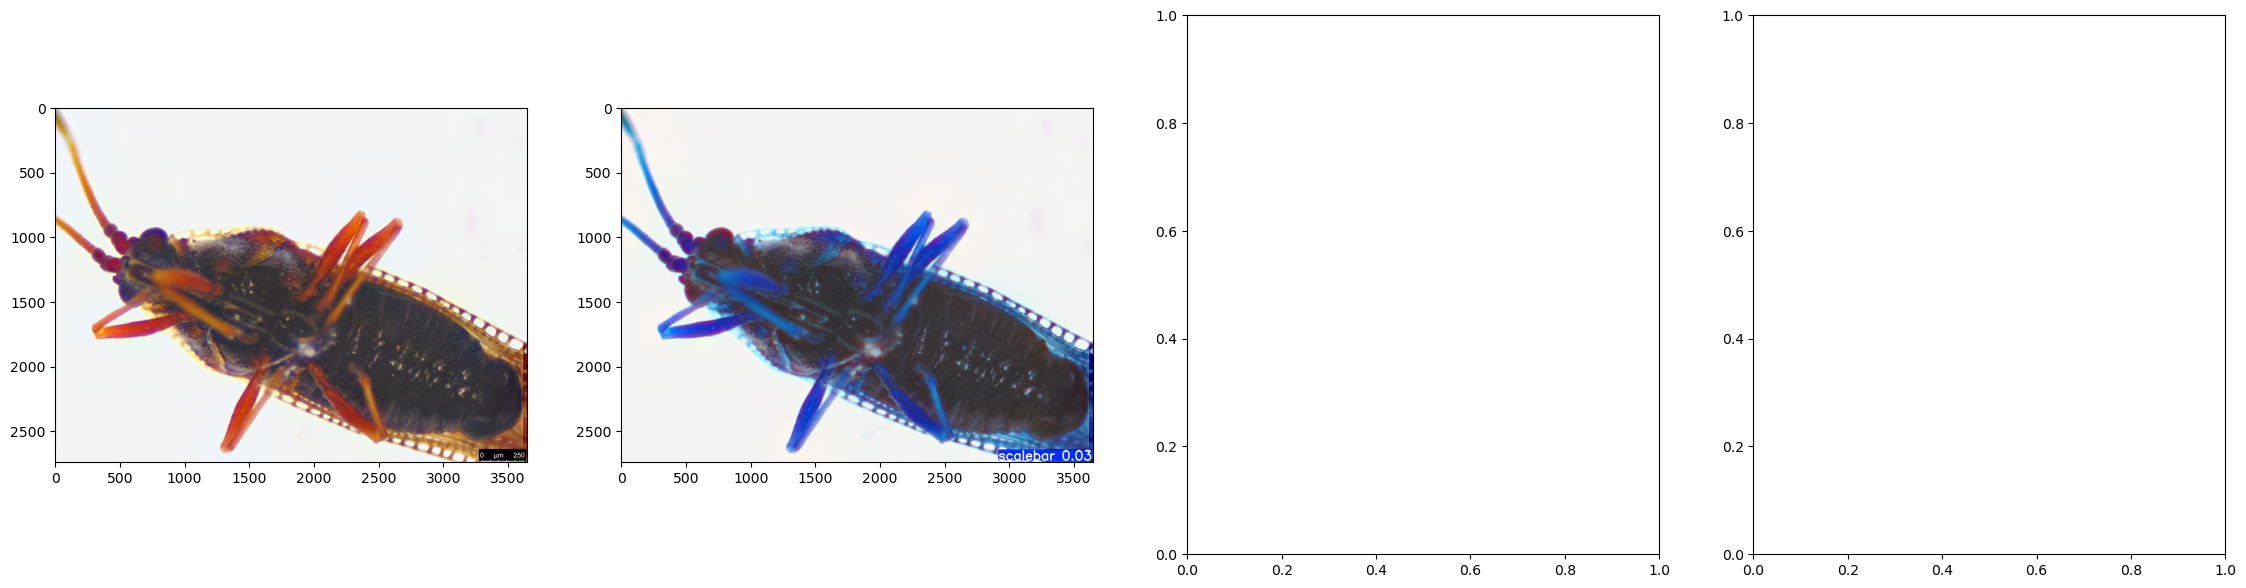

Image: BIOUG84663-G11.47cc2955, Scale Bar Found: False, Label Present: True
Image file for BIOUG84663-G11.47cc2955 not found.
Image file for BIOUG84663-G11.47cc2955 not found.


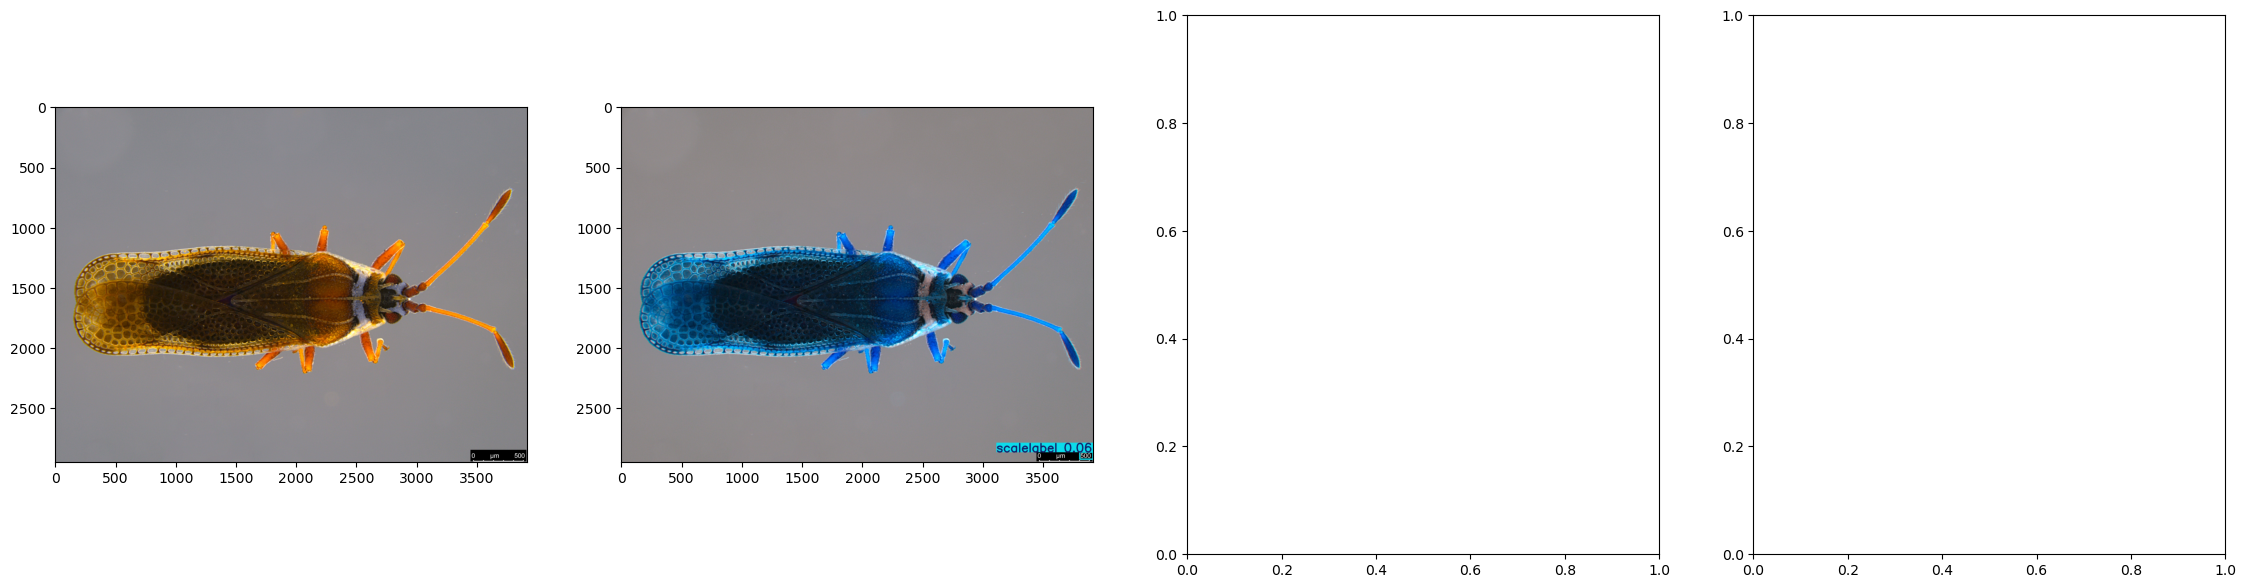

Image: BIOUG84663-G11.9b123161, Scale Bar Found: False, Label Present: True
Image file for BIOUG84663-G11.9b123161 not found.
Image file for BIOUG84663-G11.9b123161 not found.


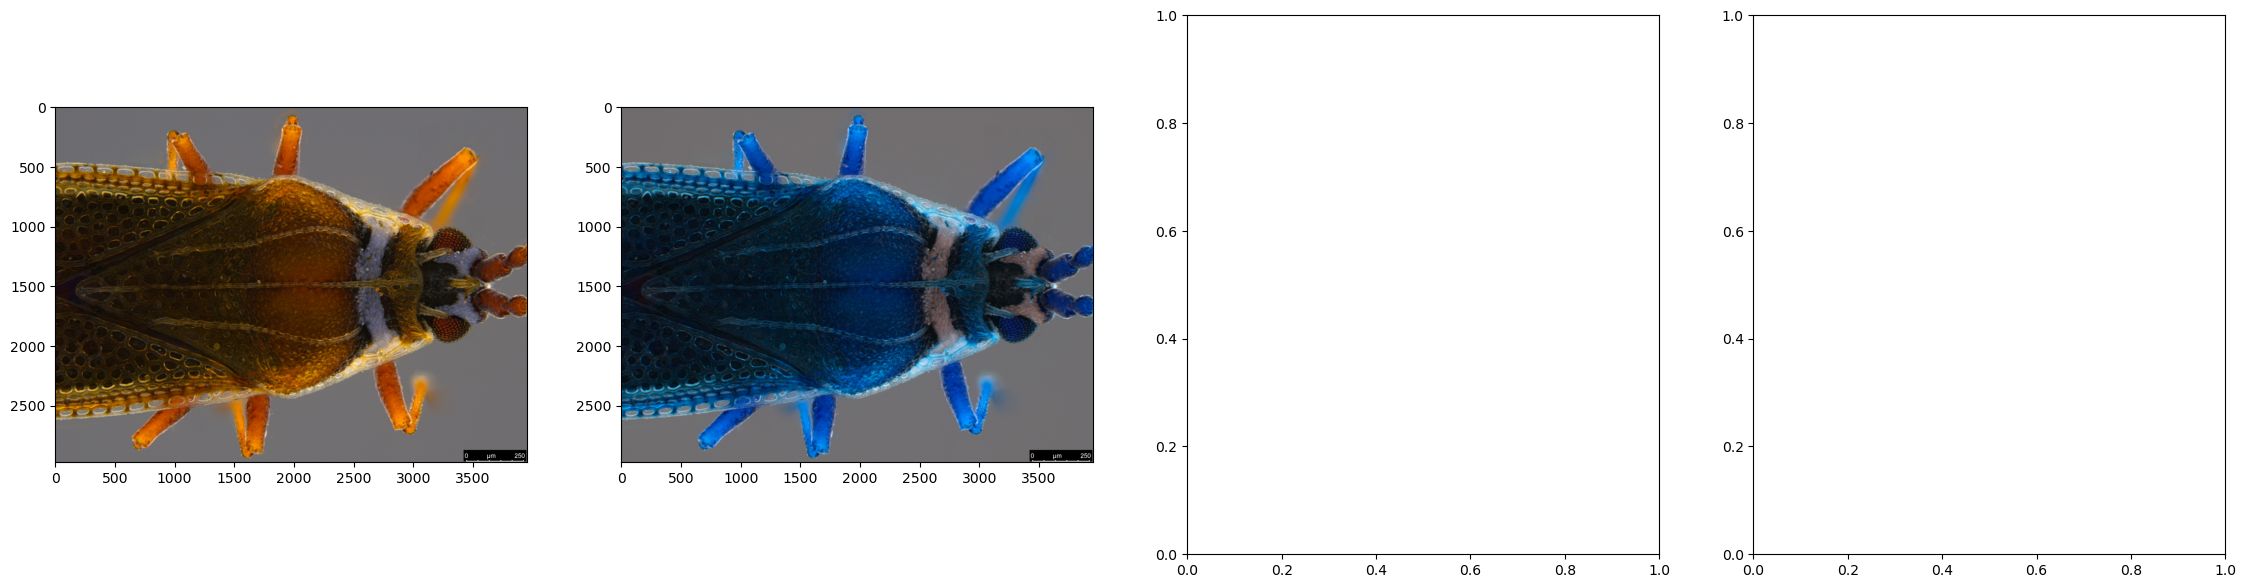

Image: BIOUG84663-G11.cbc0e20f, Scale Bar Found: False, Label Present: True
Image file for BIOUG84663-G11.cbc0e20f not found.
Image file for BIOUG84663-G11.cbc0e20f not found.


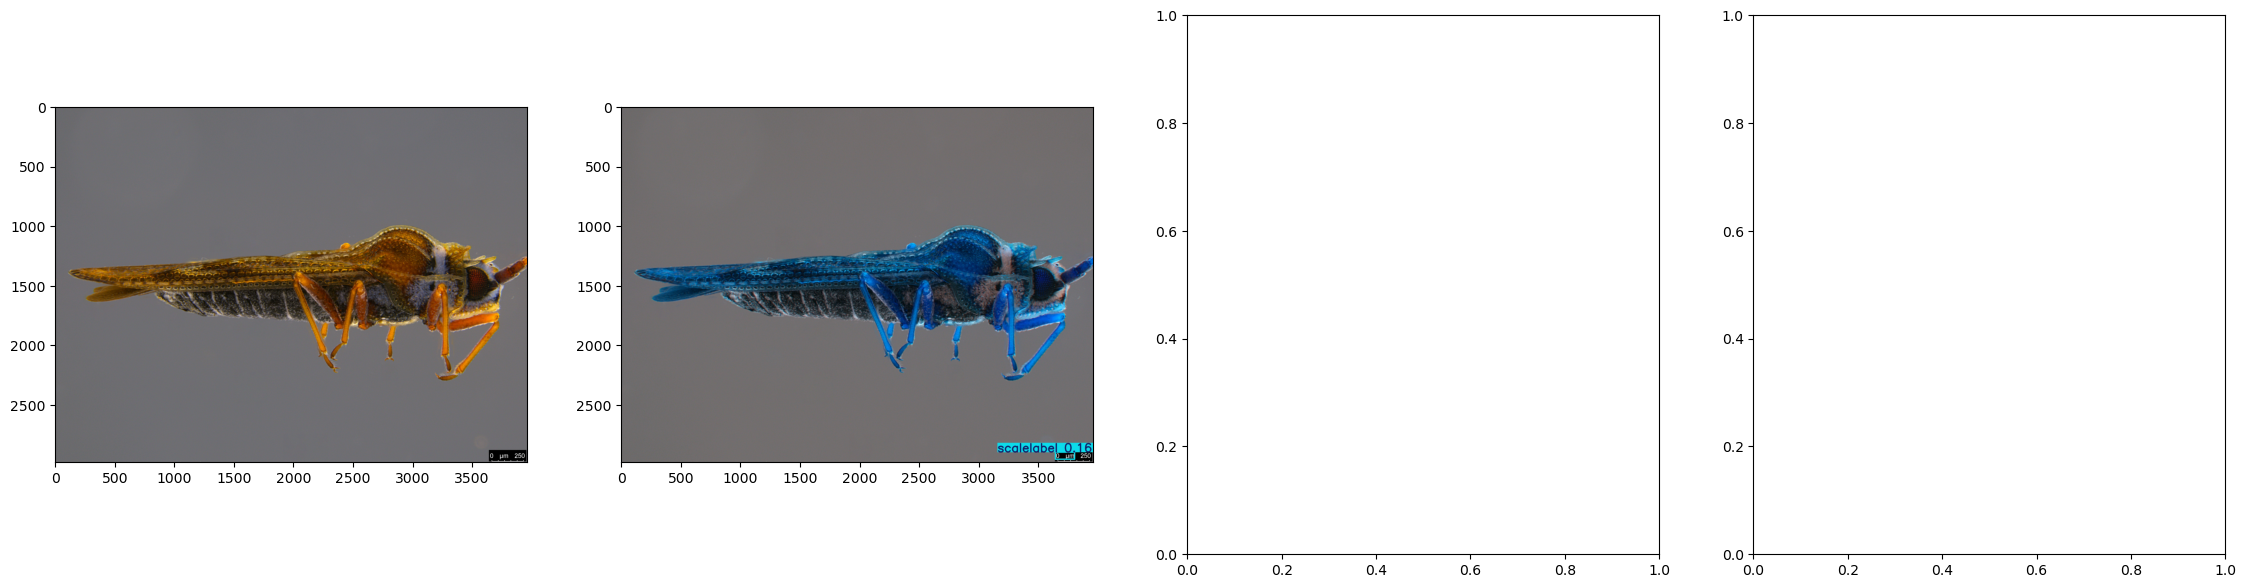

Image: BIOUG84663-G11.d7871f7e, Scale Bar Found: False, Label Present: True
Image file for BIOUG84663-G11.d7871f7e not found.
Image file for BIOUG84663-G11.d7871f7e not found.


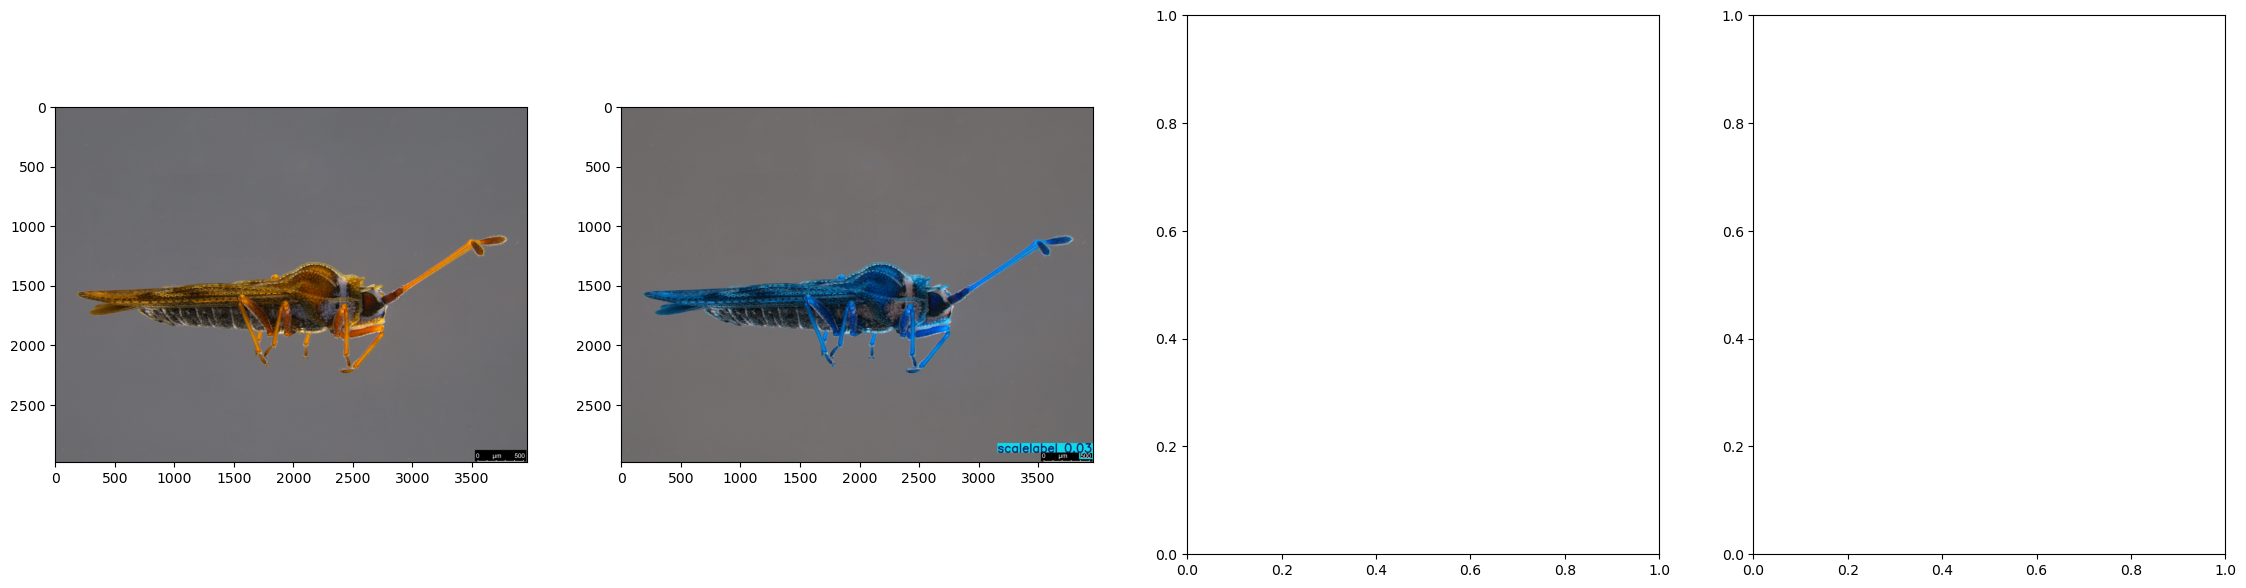

Image: BIOUG84663-G11.dc08a39f, Scale Bar Found: False, Label Present: True
Image file for BIOUG84663-G11.dc08a39f not found.
Image file for BIOUG84663-G11.dc08a39f not found.


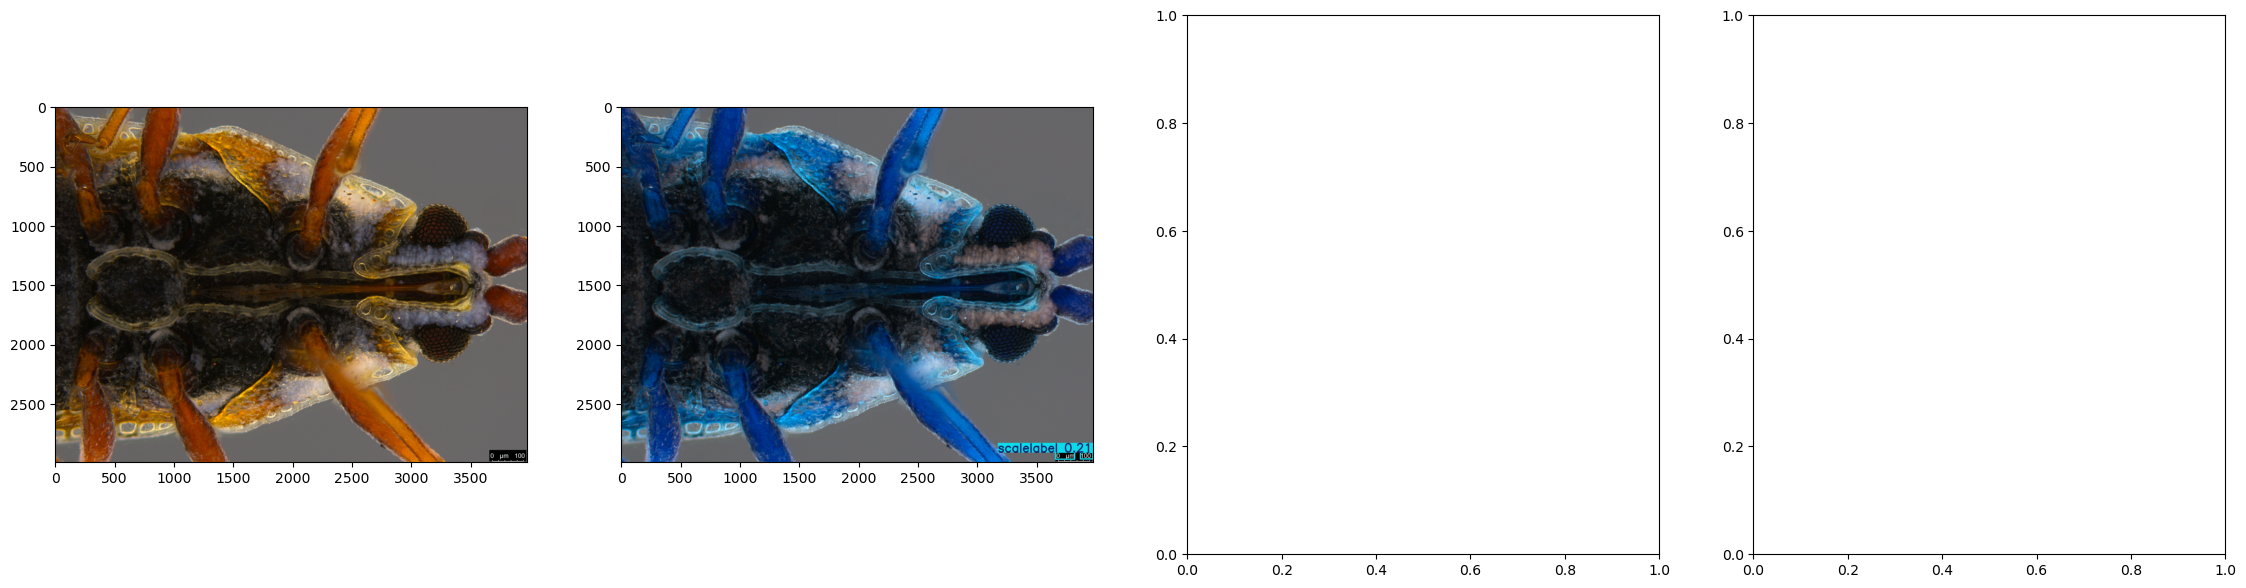

Image: BIOUG84663-G11.e9b1be6c, Scale Bar Found: False, Label Present: True
Image file for BIOUG84663-G11.e9b1be6c not found.
Image file for BIOUG84663-G11.e9b1be6c not found.


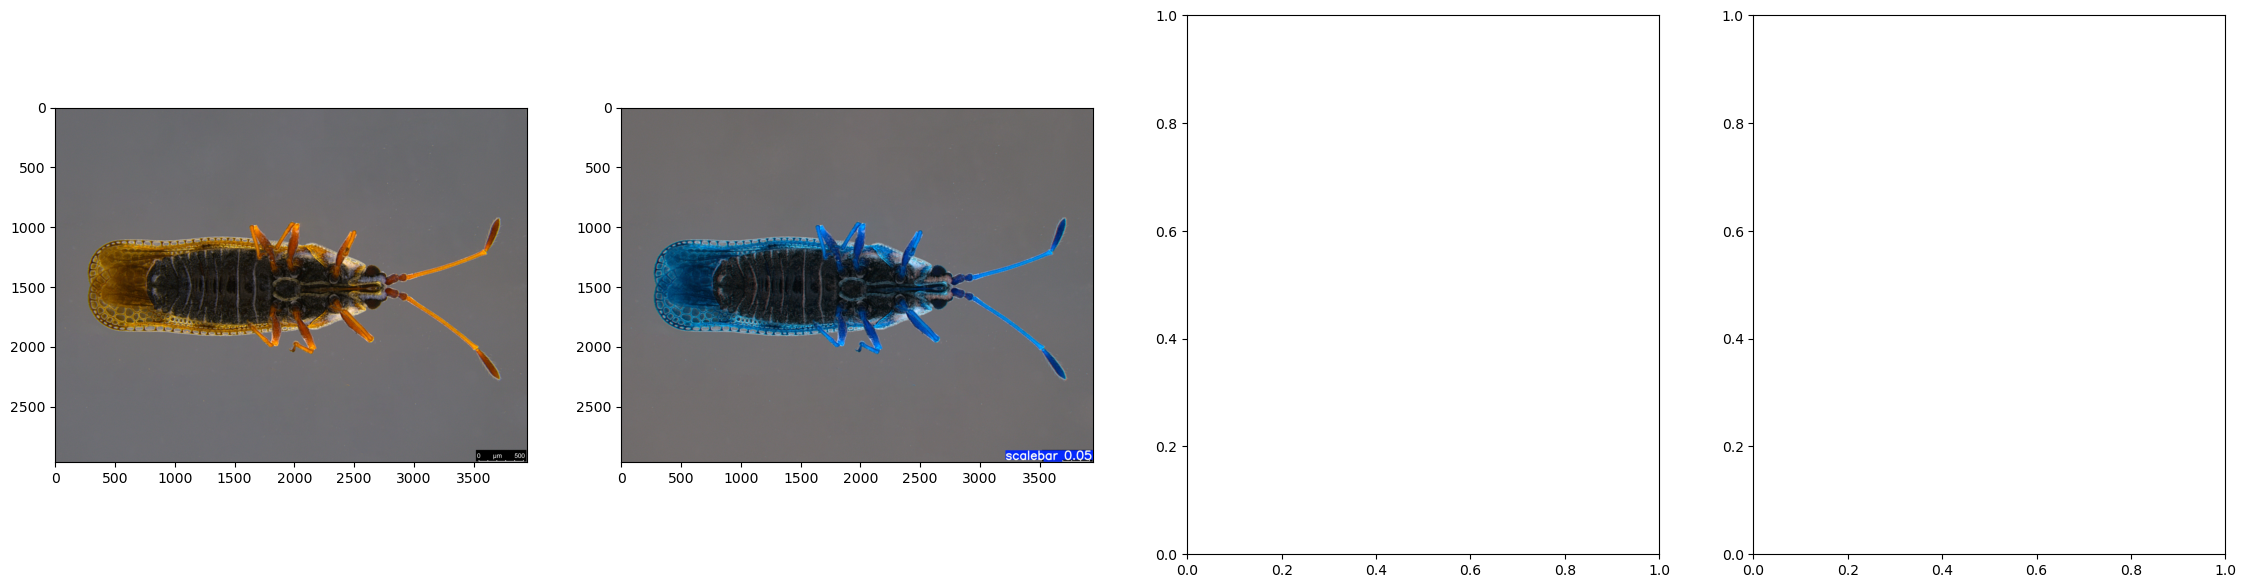

Image: BIOUG85754-A12.3b8e9942, Scale Bar Found: False, Label Present: True
Image file for BIOUG85754-A12.3b8e9942 not found.
Image file for BIOUG85754-A12.3b8e9942 not found.


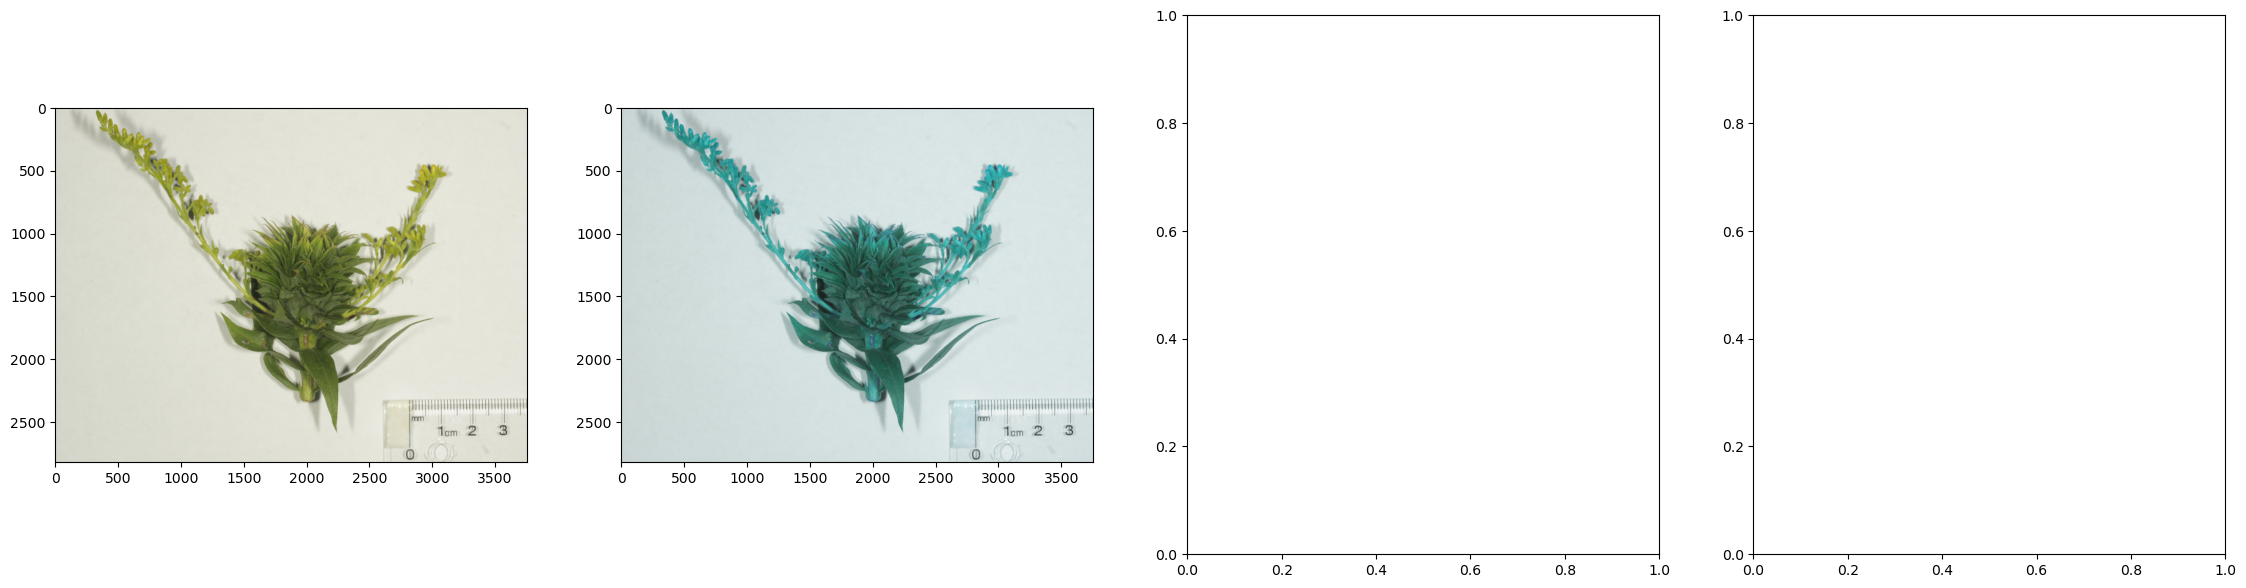

Image: BIOUG85754-C04.a85fdd1e, Scale Bar Found: False, Label Present: True
Image file for BIOUG85754-C04.a85fdd1e not found.
Image file for BIOUG85754-C04.a85fdd1e not found.


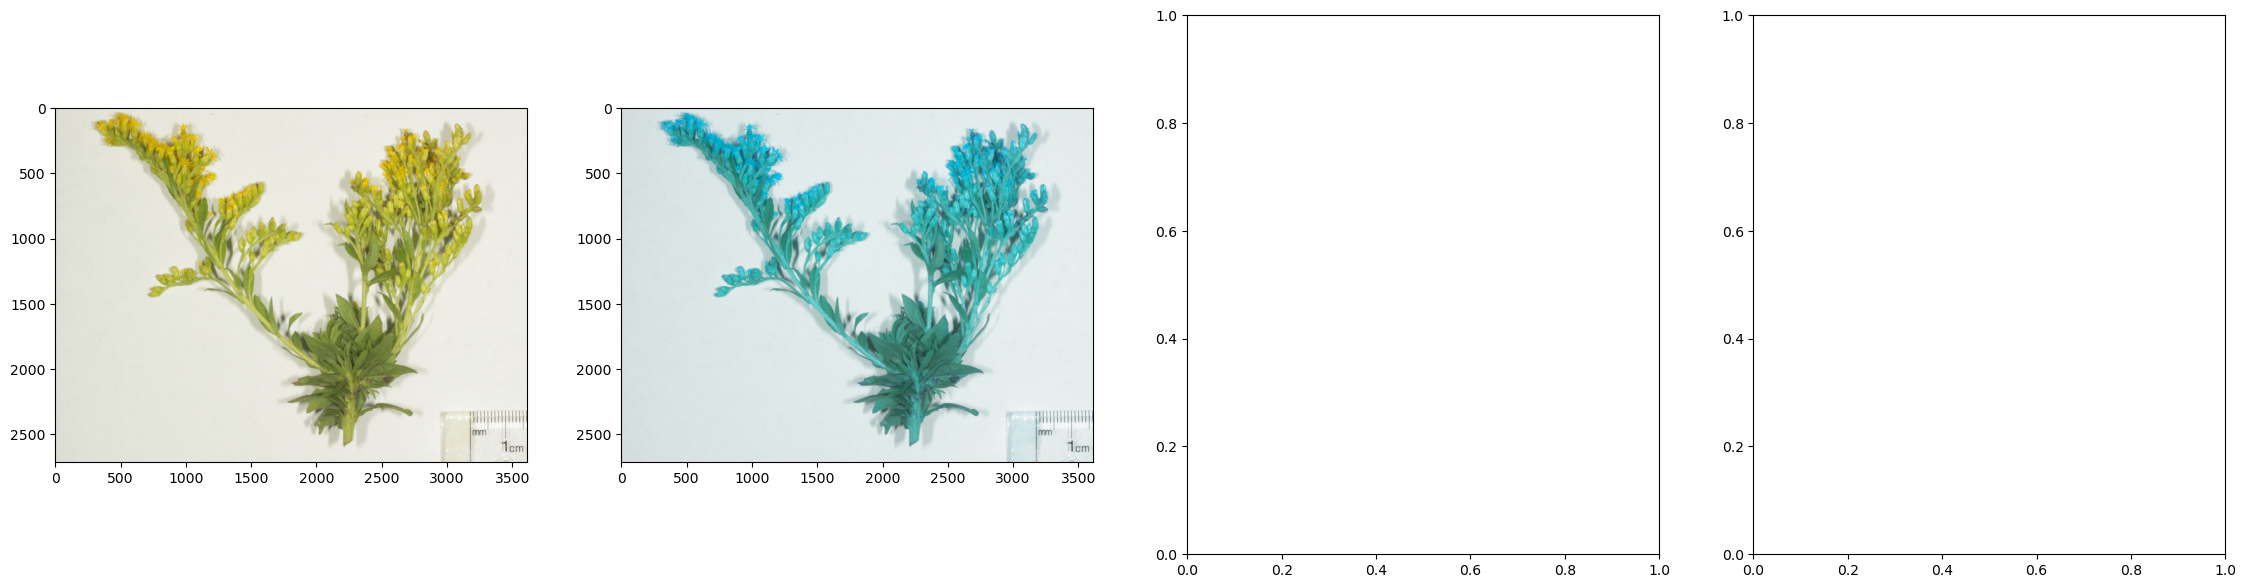

Image: BIOUG85755-H07.7b911bc5, Scale Bar Found: False, Label Present: True
Image file for BIOUG85755-H07.7b911bc5 not found.
Image file for BIOUG85755-H07.7b911bc5 not found.


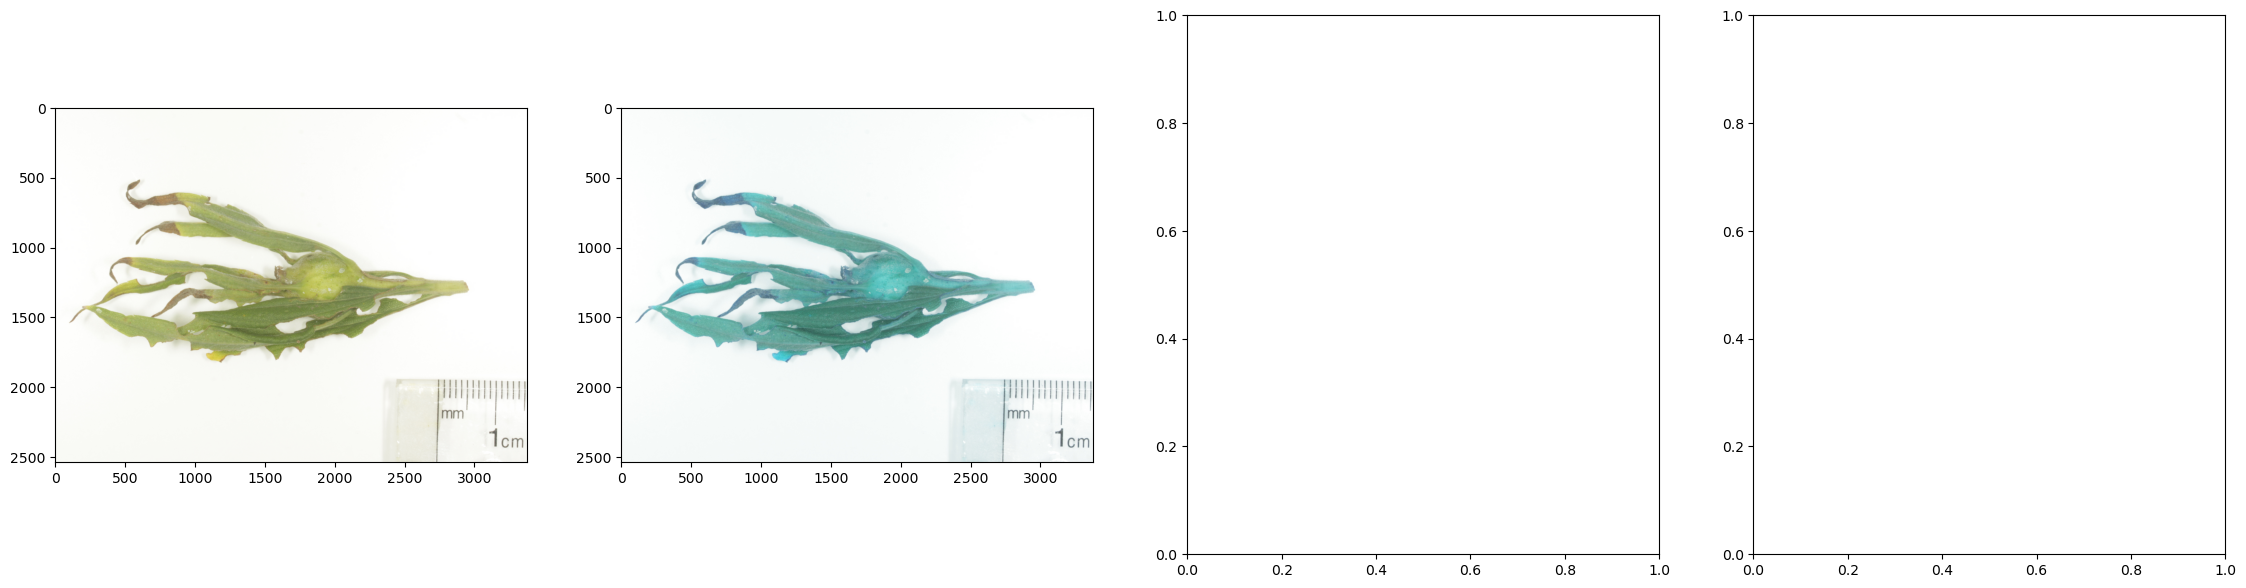

Image: NSWHA1614-23, Scale Bar Found: True, Label Present: True


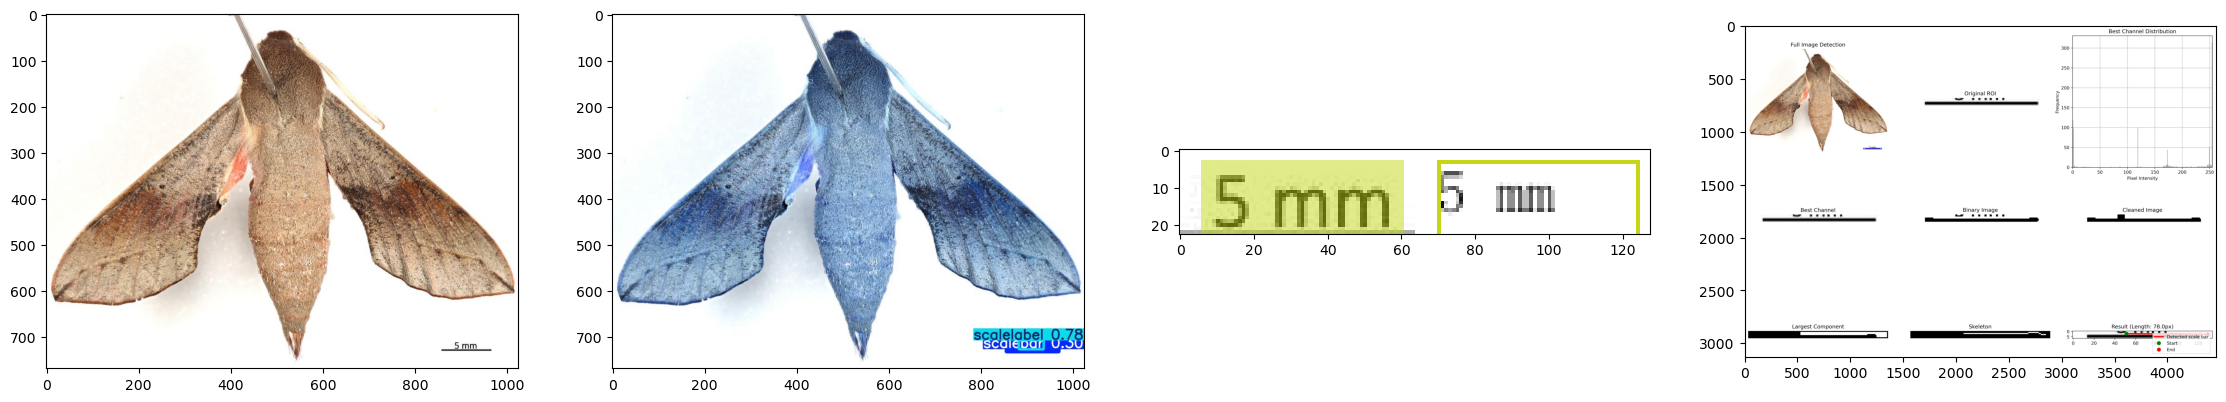

Image: NSWHA1668-23, Scale Bar Found: False, Label Present: True
Image file for NSWHA1668-23 not found.


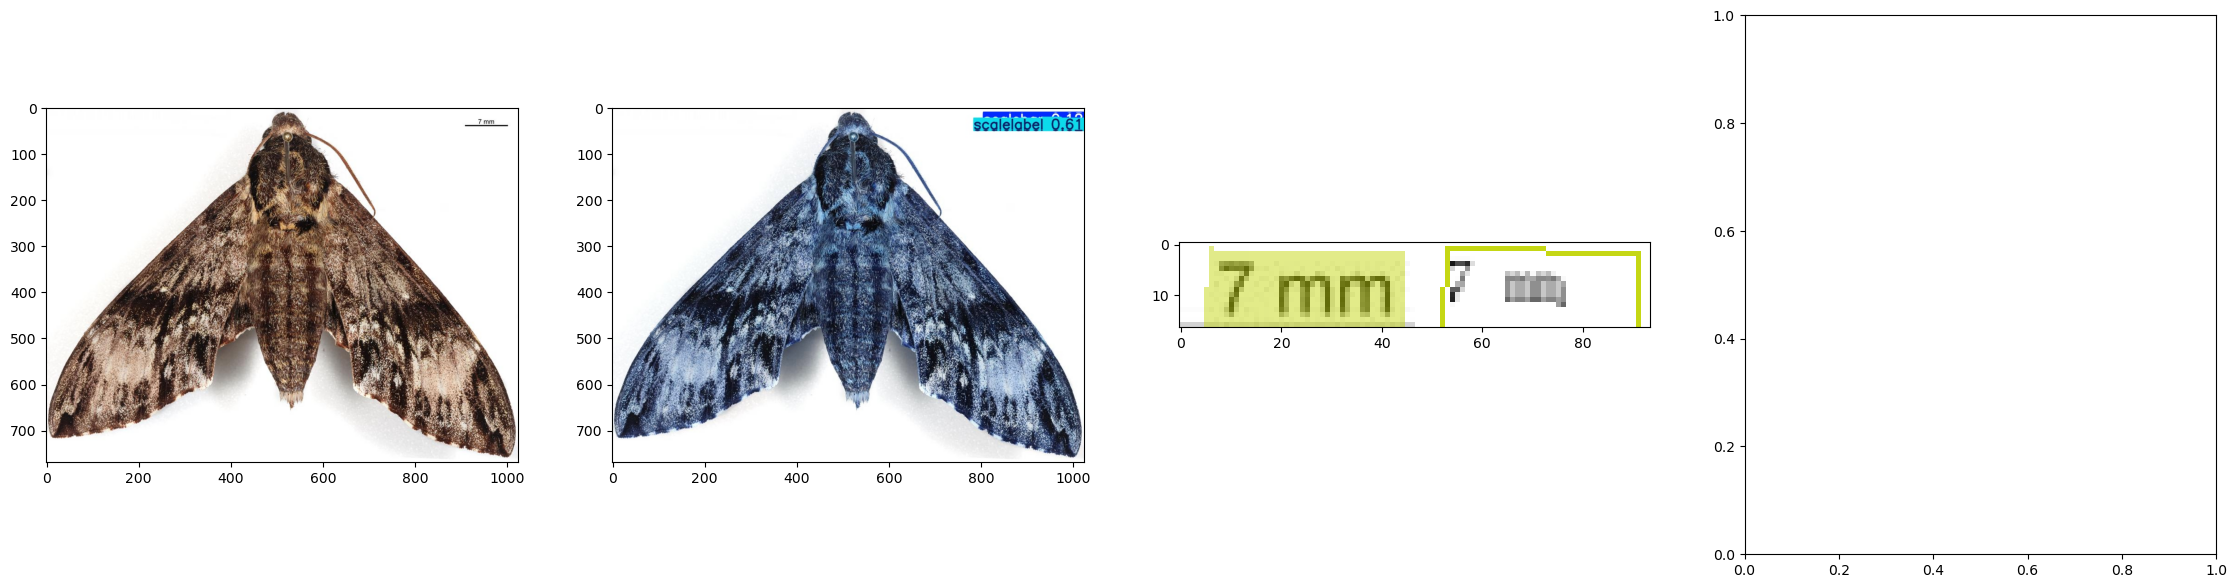

In [8]:
# Error analysis
errors = (
    (detection['scale_bar_found'] != detection['label'].notnull()) |
    ((detection['declared_scale_length'] != detection['value']) & (detection['declared_scale_length'].notnull())) |
    ((detection['units'] != detection['unit']) & (detection['units'].notnull())) |
    (np.abs(recognition['measured_scale_length'] - recognition['bar_size']) / recognition['bar_size'] > 0.07)
)
print(f"Number of error cases: {errors.sum()} out of {len(detection)}")

# Visualize errors
error_cases = detection[errors]
for idx, row in error_cases.iterrows():
    print(f"Image: {idx}, Scale Bar Found: {row['scale_bar_found']}, Label Present: {row['label'] is not None}")
    # Load and display image if needed
    try:
        plt.figure(figsize=(28, 7))
        plt.subplot(1, 4, 1)
        plt.imshow(plt.imread(f"data/annot/{idx}.jpg"))
    except FileNotFoundError:
        print(f"Image file for {idx} not found.")
    try:
        plt.subplot(1, 4, 2)
        plt.imshow(plt.imread(f"outputs/{idx}_yolo.jpg"))
    except FileNotFoundError:
        print(f"Image file for {idx} not found.")
    try:
        plt.subplot(1, 4, 3)
        plt.imshow(plt.imread(f"outputs/{idx}_ocr.png"))
    except FileNotFoundError:
        print(f"Image file for {idx} not found.")
    try:
        plt.subplot(1, 4, 4)
        plt.imshow(plt.imread(f"outputs/{idx}_scalebar.png"))
    except FileNotFoundError:
        print(f"Image file for {idx} not found.")
    plt.show()

In [9]:
# Copy images in error_cases `image` column from the annot folder to a separate error_analysis folder for further inspection
import shutil
os.makedirs('error_analysis', exist_ok=True)
for idx in error_cases.index:
    try:
        shutil.copy(f"data/annot/{idx}.jpg", f"error_analysis/{idx}.jpg")
    except FileNotFoundError:
        print(f"Image file for {idx} not found, cannot copy.")

In [10]:
!for img in error_analysis/*; do python src/scaledetection.py --image "$img" --plot_debug --output_dir "error_analysis_out"; done

/opt/miniconda3/envs/scale/lib/python3.11/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/emmaboehly/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/emmaboehly/.paddlex/official_models/en_PP-OCRv5_mobile_rec`.
No text labels detected.
/opt/miniconda3/envs/scale/lib/python3.11/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. Yo